In [1]:
#CRIANDO A BRONZE

from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

schema_gym_pass = 'id STRING, nome STRING, sobrenome STRING, email STRING, genero STRING, idade INT, telefone STRING, endereco STRING, plano STRING, matriculado_em STRING'
df_gympass_customer = spark.read.option("header","true").option('multiline', 'true').schema(schema_gym_pass).csv('s3a://lakehouse-demo/landing/gym_pass_customers.csv')
df_gympass_customer.write.format('delta').save('s3a://lakehouse-demo/bronze/gym_pass_customer')


schema_local_system = 'id STRING, first_name STRING, last_name STRING, email STRING, gender STRING, age INT, plan STRING, enrollment_in STRING'
df_local_system_customer = spark.read.option("header","true").option('multiline', 'true').schema(schema_local_system).csv('s3a://lakehouse-demo/landing/local_system_customers.csv')
df_local_system_customer.write.format('delta').save('s3a://lakehouse-demo/bronze/local_system_customer')


In [2]:
#CRIANDO A SILVER DE PLANOS

from pyspark.sql.functions import col, monotonically_increasing_id


df_customer_gympass = spark.read.format("delta").load('s3a://lakehouse-demo/bronze/local_system_customer')
df_plans = df_customer_gympass.select(col('plan').alias('plano_nome')).distinct()
df_plans = df_plans.withColumn('id_plano', monotonically_increasing_id()+1)
df_plans.write.format('delta').save('s3a://lakehouse-demo/silver/plans')

In [3]:
#CRIANDO A SILVER DE CUSTOMER

from pyspark.sql.functions import lit, to_date, when, broadcast

df_plans = spark.read.format("delta").load('s3a://lakehouse-demo/silver/plans')


df_local_system_customer = spark.read.format("delta").load('s3a://lakehouse-demo/bronze/local_system_customer')
df_local_system_customer = df_local_system_customer\
                           .withColumnRenamed('first_name', 'nome')\
                           .withColumnRenamed('last_name', 'sobrenome')\
                           .withColumnRenamed('gender', 'genero')\
                           .withColumnRenamed('age', 'idade')\
                           .withColumnRenamed('enrollment_in', 'matriculado_em')\
                           .withColumnRenamed('plan', 'plano')
df_local_system_customer = df_local_system_customer\
                           .withColumn('telefone', lit('Não definido'))\
                           .withColumn('endereco', lit('Não definido'))
df_local_system_customer = df_local_system_customer.withColumn('fonte', lit('sistema_local'))



df_customer_gympass = spark.read.format("delta").load('s3a://lakehouse-demo/bronze/gym_pass_customer')
df_customer_gympass = df_customer_gympass.withColumn('fonte', lit('gympass'))

df_union = df_local_system_customer.unionByName(df_customer_gympass)
df_union = df_union.withColumn('matriculado_em', to_date(col('matriculado_em'), 'yyyy-MM-dd').cast('date'))
df_union = df_union.withColumn('email', when(df_union.email.rlike(r'([A-Za-z0-9]+[.-_])*[A-Za-z0-9]+@[A-Za-z0-9-]+(\.[A-Z|a-z]{2,})+'), col('email')).otherwise(lit('Não definido')))
df_plans = spark.read.format("delta").load('s3a://lakehouse-demo/silver/plans')
df_union = df_union.join(broadcast(df_plans), df_union['plano'] == df_plans['plano_nome'], 'inner')
df_union = df_union.drop('plano_nome', 'plano')
df_union.write.format('delta').save('s3a://lakehouse-demo/silver/customer')

<AxesSubplot: xlabel='year_month'>

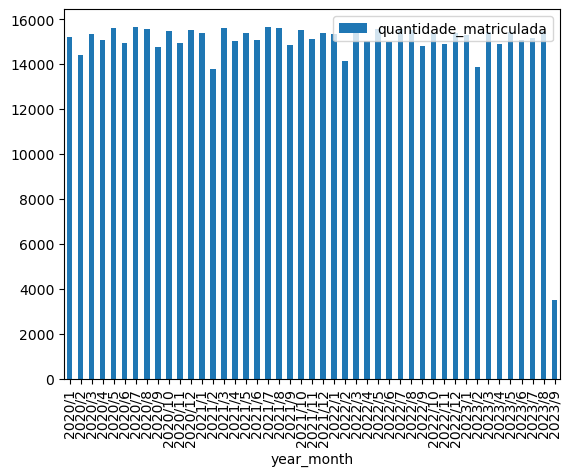

In [4]:
#CRIANDO A GOLD


from pyspark.sql import SparkSession
from pyspark.sql.functions import col, month, year, concat_ws

df_customer_silver = spark.read.format("delta").load('s3a://lakehouse-demo/silver/customer')
df_customer_silver = df_customer_silver.groupBy(year(col('matriculado_em')).alias('year'), month(col('matriculado_em')).alias('month')).agg({'id': 'count'})
df_customer_silver = df_customer_silver.orderBy('year', 'month')
df_customer_silver = df_customer_silver.withColumnRenamed('count(id)', 'quantidade_matriculada')

df = df_customer_silver.withColumn('year_month', concat_ws('/', col('year'),  col('month')))
df.toPandas().plot.bar(y='quantidade_matriculada', x='year_month')


+-------------+----------------------+
|        fonte|quantidade_matriculada|
+-------------+----------------------+
|sistema_local|                535678|
|      gympass|                135479|
+-------------+----------------------+



<AxesSubplot: xlabel='fonte'>

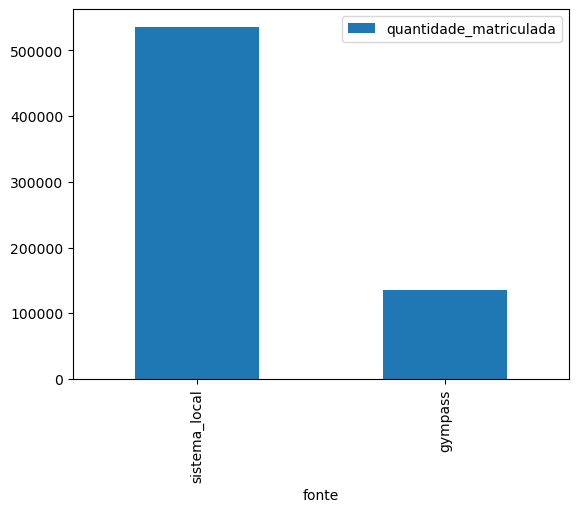

In [5]:
#CRIANDO A GOLD


spark = SparkSession.builder.getOrCreate()
df_customer_silver = spark.read.format("delta").load('s3a://lakehouse-demo/silver/customer')

df_customer_silver = df_customer_silver.withColumn('matriculado_em', to_date(col('matriculado_em'), 'M/d/yyyy').cast('date'))
df_customer_silver = df_customer_silver.groupBy(col('fonte')).agg({'id': 'count'})
df_customer_silver = df_customer_silver.withColumnRenamed('count(id)', 'quantidade_matriculada')

df_customer_silver.show()
df_customer_silver.toPandas().plot.bar(y='quantidade_matriculada', x='fonte')

+--------+--------+---------+--------------------+--------+-----+--------------+--------------------+--------------------+-------+--------+
|      id|    nome|sobrenome|               email|  genero|idade|matriculado_em|            telefone|            endereco|  fonte|id_plano|
+--------+--------+---------+--------------------+--------+-----+--------------+--------------------+--------------------+-------+--------+
|38395933| Kenneth| Martinez|mariocarroll@exam...|Feminino|   43|    2023-01-02|        257-481-9351|37631 Kimberly Ci...|gympass|       2|
|74662842|    Anna|      Roy|   clane@example.org|Feminino|   58|    2023-01-05|  341.804.1470x87842|PSC 7748, Box 856...|gympass|       2|
|28954053|   James|  Bennett| nsavage@example.org|Feminino|   40|    2023-01-09|        954-255-7068|9282 Jessica Burg...|gympass|       2|
|53769736|   Jared|   Miller|wilsonmaria@examp...|Feminino|   38|    2023-01-06| (971)510-1522x03494|16157 Douglas Squ...|gympass|       2|
|95861656| Felicia| 

<AxesSubplot: xlabel='ano'>

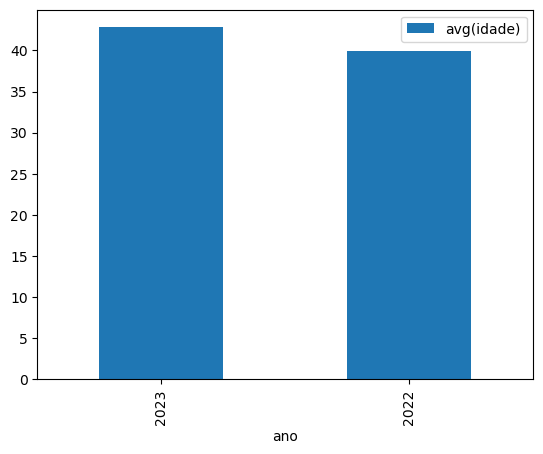

In [6]:
#CRIANDO GOLD


spark = SparkSession.builder.getOrCreate()
df_customer_silver = spark.read.format("delta").load('s3a://lakehouse-demo/silver/customer')

df_customer_silver = df_customer_silver\
                                .filter((col('id_plano') == '2') & (col('genero') == 'Feminino') & (col('matriculado_em') > '2022-12-29') & (col('matriculado_em') < '2023-01-12'))
df_customer_silver.show()
df_customer_silver = df_customer_silver.withColumn('ano', year(col('matriculado_em')))
df_customer_silver = df_customer_silver.groupBy('ano').agg({'idade': 'average'})

df_customer_silver.show()
df_customer_silver.toPandas().plot.bar(y='avg(idade)', x='ano')